In [1]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
conn_str = (
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=localhost;"               # default instance
    "DATABASE=DW_Education;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
if conn:
    print("Connected successfully")

Connected successfully


In [3]:
query = """
SELECT
    f.IPS,
    f."Taux de réussite" AS Taux_Reussite,
    f."Taux de mentions" AS Taux_Mentions,
    f.Nb_eleves,

    -- Geographic info
    g.Code_postal AS Code_Postal,
    g.Nom_commune AS Ville,
    g.Libelle_region AS Region,

    -- Etablissement info
    e.UAI AS UAI,
    e.Nom_etablissement AS Nom_Etablissement,
    e.Statut_public_prive AS Statut_Etablissement,

    -- Date info
    d.Annee,
    d.Mois,
    d.Jour,

    -- Section info
    s.Code_Section,

    -- Voie info
    v.Code_Voie,

    -- Type Etablissement info
    t.Code_TypeEtab,

    -- Service info
    srv.Code_Service

FROM dbo.factEtablissement2 AS f

-- Join each dimension
LEFT JOIN dbo.dim_geographie AS g
    ON f.Geographie_FK = g.Geographie_PK

LEFT JOIN dbo.dim_etablissment AS e
    ON f.Etablissment_FK = e.Etablissment_PK

LEFT JOIN dbo.dim_Date AS d
    ON f.Date_FK = d.Date_PK

LEFT JOIN dbo.dim_Section AS s
    ON f.Section_FK = s.Section_PK

LEFT JOIN dbo.dim_Voie AS v
    ON f.Voie_FK = v.Voie_PK

LEFT JOIN dbo.dim_TypeEtablissement AS t
    ON f.TypeEtab_FK = t.TypeEtab_PK

LEFT JOIN dbo.dim_Service AS srv
    ON f.Service_FK = srv.Service_PK;

"""

df = pd.read_sql(query, conn)
df.head()

C:\Users\mk\AppData\Local\Temp\ipykernel_16228\2984369686.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,IPS,Taux_Reussite,Taux_Mentions,Nb_eleves,Code_Postal,Ville,Region,UAI,Nom_Etablissement,Statut_Etablissement,Annee,Mois,Jour,Code_Section,Code_Voie,Code_TypeEtab,Code_Service
0,121.4,98,55.0,442.0,25000,Besançon,Bourgogne-Franche-Comté,0251021Z,Lycée général et technologique privé Saint-Paul,Privé,1967.0,3.0,30.0,ART,G,L,RES
1,121.4,98,55.0,442.0,25000,Besançon,Bourgogne-Franche-Comté,0251021Z,Lycée général et technologique privé Saint-Paul,Privé,1967.0,3.0,30.0,ART,T,L,RES
2,121.4,98,55.0,442.0,25000,Besançon,Bourgogne-Franche-Comté,0251021Z,Lycée général et technologique privé Saint-Paul,Privé,1967.0,3.0,30.0,EUR,G,L,RES
3,121.4,98,55.0,442.0,25000,Besançon,Bourgogne-Franche-Comté,0251021Z,Lycée général et technologique privé Saint-Paul,Privé,1967.0,3.0,30.0,EUR,T,L,RES
4,121.4,98,55.0,442.0,25000,Besançon,Bourgogne-Franche-Comté,0251021Z,Lycée général et technologique privé Saint-Paul,Privé,1967.0,3.0,30.0,THE,G,L,RES


In [4]:
df['Taux_Reussite'] = pd.to_numeric(df['Taux_Reussite'], errors='coerce')
df['Taux_Mentions'] = pd.to_numeric(df['Taux_Mentions'], errors='coerce')
df['IPS'] = pd.to_numeric(df['IPS'], errors='coerce')
df['Nb_eleves'] = pd.to_numeric(df['Nb_eleves'], errors='coerce')
df['Annee'] = pd.to_numeric(df['Annee'], errors='coerce')


In [5]:
numeric_cols = ['IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves', 'Annee']
categorical_cols = [
    'Region', 'Code_Section', 'Code_Voie',
    'Code_Service', 'Code_TypeEtab',
    'Statut_Etablissement'
]

df['Nb_eleves'] = df['Nb_eleves'].fillna(df['Nb_eleves'].median())
df['Taux_Reussite'] = df['Taux_Reussite'].fillna(df['Taux_Reussite'].median())
df['Taux_Mentions'] = df['Taux_Mentions'].fillna(df['Taux_Mentions'].mean())
df['IPS'] = df['IPS'].fillna(df['IPS'].mean())
df['Annee'] = df['Annee'].fillna(df['Annee'].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [6]:
df_grouped = df.groupby('UAI').agg({
    'IPS': 'median',
    'Taux_Reussite': 'median',
    'Taux_Mentions': 'median',
    'Nb_eleves': 'first',
    'Region': lambda x: x.mode()[0],
    'Code_TypeEtab': lambda x: x.mode()[0],
    'Code_Section': lambda x: ','.join(sorted(set(x))),
    'Code_Service': lambda x: ','.join(sorted(set(x))),
    'Code_Voie': lambda x: ','.join(sorted(set(x))),
    'Statut_Etablissement': 'first'
}).reset_index()

print(df_grouped.shape)


(51361, 11)


In [7]:
def remove_outliers_iqr(data, cols):
    cleaned = data.copy()
    for col in cols:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[
            (cleaned[col] >= lower) &
            (cleaned[col] <= upper)
        ]
    return cleaned

df_grouped = remove_outliers_iqr(df_grouped, ['IPS', 'Nb_eleves'])

print(df_grouped.shape)


(39531, 11)


In [8]:
# Sections
df_grouped['Section_list'] = df_grouped['Code_Section'].str.split(',')
mlb_sec = MultiLabelBinarizer()
sec_dummies = pd.DataFrame(
    mlb_sec.fit_transform(df_grouped['Section_list']),
    columns=[f"sec_{c}" for c in mlb_sec.classes_],
    index=df_grouped.index
)

# Services
df_grouped['Service_list'] = df_grouped['Code_Service'].str.split(',')
mlb_srv = MultiLabelBinarizer()
srv_dummies = pd.DataFrame(
    mlb_srv.fit_transform(df_grouped['Service_list']),
    columns=[f"srv_{c}" for c in mlb_srv.classes_],
    index=df_grouped.index
)

# Voies
df_grouped['Voie_list'] = df_grouped['Code_Voie'].str.split(',')
mlb_voie = MultiLabelBinarizer()
voie_dummies = pd.DataFrame(
    mlb_voie.fit_transform(df_grouped['Voie_list']),
    columns=[f"voie_{c}" for c in mlb_voie.classes_],
    index=df_grouped.index
)

df_final = pd.concat(
    [df_grouped, sec_dummies, srv_dummies, voie_dummies],
    axis=1
)

print(df_final.shape)


(39531, 30)


In [9]:
# -----------------------------
# FEATURE SELECTION (UNSUPERVISED)
# -----------------------------

numeric_features = [
    'IPS',
    'Taux_Reussite',
    'Taux_Mentions',
    'Nb_eleves'
]

categorical_features = ['Code_TypeEtab']

multi_hot_features = [
    c for c in df_final.columns
    if c.startswith(('sec_', 'voie_'))
]

X = df_final[numeric_features + categorical_features + multi_hot_features]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print("Shape finale de X :", X.shape)


Shape finale de X : (39531, 15)


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


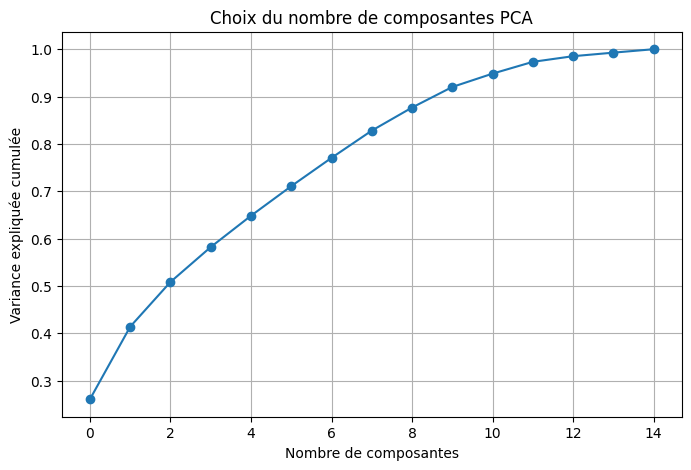

In [11]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Choix du nombre de composantes PCA")
plt.grid()
plt.show()


In [12]:
pca = PCA(n_components=2)
X_pca_2 = pca.fit_transform(X_scaled)


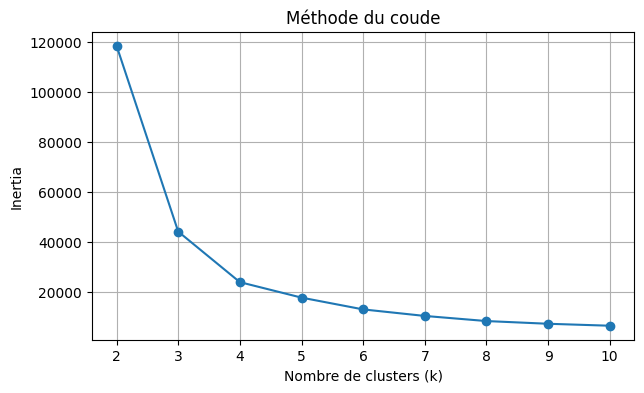

In [13]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_2)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertia")
plt.title("Méthode du coude")
plt.grid()
plt.show()


In [14]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_2)

df_final['Cluster'] = clusters


In [15]:
sil_score = silhouette_score(X_pca_2, clusters)
print("Silhouette Score :", sil_score)


Silhouette Score : 0.9268972328338546


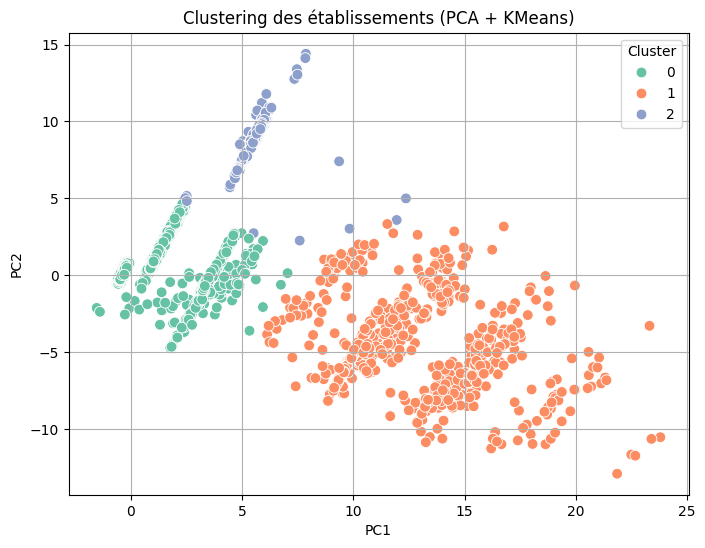

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca_2[:,0],
    y=X_pca_2[:,1],
    hue=clusters,
    palette='Set2',
    s=60
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering des établissements (PCA + KMeans)")
plt.legend(title="Cluster")
plt.grid()
plt.show()


In [17]:
cluster_profile = df_final.groupby('Cluster')[
    ['IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves']
].mean()

cluster_profile


,IPS,Taux_Reussite,Taux_Mentions,Nb_eleves
Cluster,,,,
0,102.407864,91.000759,51.634486,124.538357
1,99.786708,92.029283,52.229232,133.613470
2,100.660302,90.980122,73.332812,290.348624
